<a href="https://colab.research.google.com/github/clv07/stroke-of-luck/blob/Data-import/12SL_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Load Data
dataset = pd.read_csv("dataset.csv")

In [10]:
# Data Pre-Processing
columns_to_drop = ["PatientID", "Source","Phys_Codes","MI_12SL","MI_Phys","TestID","PatientAge","Gender","AcquisitionDateTime_DT","12SL_Codes"]
df_cols = dataset.drop(columns=columns_to_drop)
columns_to_drop = ["Source","Phys_Codes","TestID","PatientAge","Gender","AcquisitionDateTime_DT","12SL_Codes",'MI_12SL']
df_patients = dataset.drop(columns=columns_to_drop)

In [11]:
# PCA
scaler = StandardScaler()
df_cols = df_cols.dropna()  # Drop missing values if any
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
pca.fit(X_scaled)  # Fit PCA, but don't transform or get components data

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

# Get the components (feature loadings) from PCA
components = pca.components_

# Get the feature names (labels) from the original dataset
feature_names = df_cols.columns

# Find significant features (those with high loadings in the principal components)
# We'll define "significant" as having an absolute loading > a certain threshold (e.g., 0.1)
threshold = 0.1

# Create a list to store the significant features
significant_features = set()

for i, component in enumerate(components):
    # Get the absolute value of the loadings for each feature in this component
    feature_contributions = pd.Series(component, index=feature_names)

    # Add features with absolute loading greater than threshold to the set
    significant_features.update(feature_contributions[feature_contributions.abs() > threshold].index)

# Print the significant features
print("Significant Features:", significant_features)

# Step 2: Filter the original dataset to keep only significant features
df_significant_features = df_cols[list(significant_features)]

Number of components selected: 277
Total variance explained: 0.9501401527639174
Significant Features: {'RP_Duration_V2', 'STELEV_V2', 'Q_Duration_AVL', 'Q_Area_V5', 'P_PeakTime_II', 'S_PeakAmpl_V6', 'Q_Duration_II', 'SP_Area_AVR', 'RP_PeakTime_AVL', 'P_PeakTime_V2', 'PP_Duration_V1', 'P_RInterval', 'PP_PeakTime_I', 'T_PeakAmpl_V5', 'PP_Area_V4', 'T_Area_V5', 'PP_Duration_V3', 'QRS_Balance_AVL', 'RP_Area_V3', 'P_OnsetAmpl_I', 'Q_Area_V6', 'RP_Duration_I', 'P_Duration_AVR', 'PPDEEP_V1', 'SP_Duration_V3', 'TP_Area_AVR', 'SP_Area_V2', 'Q_Area_I', 'P_Duration_I', 'SP_PeakAmpl_V1', 'JELEV_V1', 'TP_Area_aVF', 'PP_PeakTime_II', 'STINJ_V6', 'JELEV_V3', 'RP_PeakAmpl_V5', 'S_PeakAmpl_V2', 'S_PeakTime_II', 'PAxis', 'PP_Duration_II', 'SP_Area_III', 'P_Duration_II', 'Max_R_Ampl_V5', 'SP_PeakAmpl_V5', 'TP_Area_V3', 'R_Duration_V6', 'PP_Duration_V5', 'Q_PeakTime_I', 'PP_PeakAmpl_V5', 'TP_PeakTime_V6', 'Q_TInterval', 'QTc_Bazett', 'Q_PeakTime_V6', 'RP_PeakTime_V5', 'DLTWV_V1', 'PP_PeakAmpl_V4', 'QRS_T_

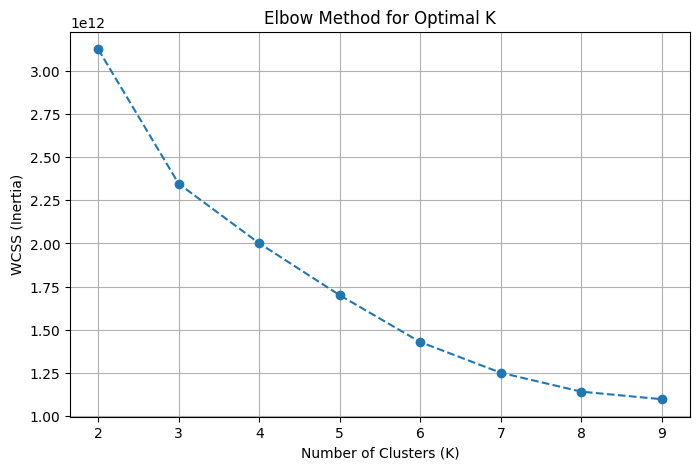

In [ ]:
# Run K Clustering On the 277 Traits
# Step 1: Determine optimal number of clusters using Elbow Method
wcss = []  # Within-cluster sum of squares
K_range = range(2, 10)  # Test clusters from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_significant_features.transpose())
    wcss.append(kmeans.inertia_)  # Inertia = sum of squared distances to cluster center

# Step 2: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [14]:
# Step 3: Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters= 3, random_state=42, n_init=10)
df_features = pd.DataFrame(significant_features,columns=['features'])
df_features['assignment'] = kmeans.fit_predict(df_significant_features.transpose())

In [16]:
# Step 4: Seperate original dataset into seperate groupings of features
# 4a) For each cluster get a subset of the dataset with those features and if MI is present
df_features
# 4b)
# This dict will hold the separate patient DataFrames for each cluster
df_clusters = {}

# Additional useful columns (like the target label and patient ID)
extra_columns = ['PatientID', 'MI_Phys']

# For each cluster, extract only the patient data for the assigned features
for assignment, features in cluster_mapping.items():
    # Make sure all requested columns exist
    available_features = [col for col in features if col in df_patients.columns]
    all_columns = list(set(extra_columns + available_features))
    df_clusters[assignment] = df_patients[all_columns]
df_clusters

{0:        RP_Duration_V2  STELEV_V2  Q_Duration_AVL  Q_Area_V5  P_PeakTime_II  \
 0                   0          0               0          0             70   
 1                   0          0               0          0             52   
 2                   0          4              17          0             44   
 3                   0          0               0         33             48   
 4                   0          0               0          0             54   
 ...               ...        ...             ...        ...            ...   
 77312               0          4              21          0             58   
 77313               0          0               0         87             64   
 77314               0          0              84          0             56   
 77315               0          4               0         12             32   
 77316               0          0              18          0             42   
 
        S_PeakAmpl_V6  Q_Duration_II  SP_Area_A

In [17]:
rf_models = {}

for cluster_id, subset in df_clusters.items():
    # Drop target + non-feature columns
    X = subset.drop(columns=['MI_Phys', 'PatientID'])
    y = subset['MI_Phys']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    print(f"\nCluster {cluster_id} Model Performance:")
    print(classification_report(y_test, y_pred))

    rf_models[cluster_id] = rf


Cluster 0 Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     13895
           1       0.82      0.31      0.45      1569

    accuracy                           0.92     15464
   macro avg       0.87      0.65      0.70     15464
weighted avg       0.92      0.92      0.91     15464


Cluster 1 Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     13895
           1       0.71      0.15      0.24      1569

    accuracy                           0.91     15464
   macro avg       0.81      0.57      0.60     15464
weighted avg       0.89      0.91      0.88     15464


Cluster 2 Model Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     13895
           1       0.67      0.00      0.01      1569

    accuracy                           0.90     15464
   macro avg       0.78      0.50     

In [20]:
# Step 1: Build meta-dataset
first_cluster = list(df_clusters.keys())[0]
meta_data['PatientID'] = df_clusters[first_cluster]['PatientID']
meta_data['MI_Phys'] = df_clusters[first_cluster]['MI_Phys']

# Add prediction probabilities from each cluster model
for cluster_id in df_clusters:
    X_cluster = df_clusters[cluster_id].drop(columns=['MI_Phys', 'PatientID'])
    preds = rf_models[cluster_id].predict_proba(X_cluster)[:, 1]  # probability of MI=1
    meta_data[f'pred_{cluster_id}'] = preds

# Step 2: Split meta features and target
X_meta = meta_data.drop(columns=['PatientID', 'MI_Phys'])
y_meta = meta_data['MI_Phys']

X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

# Step 3: Train Random Forest as meta-model
meta_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
meta_rf.fit(X_train, y_train)

# Step 4: Evaluate meta-model
y_pred = meta_rf.predict(X_test)
print("\nMeta Random Forest Performance:")
print(classification_report(y_test, y_pred))

# Step 5 (Optional): Interpret feature importance
importances = meta_rf.feature_importances_
for feat, imp in zip(X_meta.columns, importances):
    print(f"{feat}: {imp:.4f}")


Meta Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     13895
           1       0.67      0.52      0.58      1569

    accuracy                           0.92     15464
   macro avg       0.81      0.74      0.77     15464
weighted avg       0.92      0.92      0.92     15464

pred_0: 0.5523
pred_1: 0.3720
pred_2: 0.0757
